# Tutorial: Poisson regression with CatBoost
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/regression/poisson.ipynb)

In [1]:
!pip install catboost

     |████████████████████████████████| 64.4MB 61kB/s 


In [2]:
!wget https://gist.githubusercontent.com/garkavem/06d05185e5b0685f2cd1cf37ac2a8568/raw/73e7ad0b508eab63be80a46262abc83ca77e898d/elon_tweets.csv

--2020-04-01 20:45:11--  https://gist.githubusercontent.com/garkavem/06d05185e5b0685f2cd1cf37ac2a8568/raw/73e7ad0b508eab63be80a46262abc83ca77e898d/elon_tweets.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6133224 (5.8M) [text/plain]
Saving to: ‘elon_tweets.csv’

elon_tweets.csv     100%[===================>]   5.85M  --.-KB/s    in 0.1s    

2020-04-01 20:45:12 (51.3 MB/s) - ‘elon_tweets.csv’ saved [6133224/6133224]



# In this tutorial we are going to cover the following topics:

* The concept of count-based data
* What is Poisson regression and why it is suitable for count-based data
* How to build a Poisson regression model with CatBoost package
* How to predict number of likes that the tweets of Elon Musk are going to get



## What is count based data?

By definition **count data** is a data type, in which:

1. The observations can take only the non-negative integer values {0, 1, 2, 3, ...}
2. These integers arise from *counting*

More specifically in our tutorial we will focus on count-based data where each point is the number of events that have occurred over some fixed time unit $t$. We will also assume that on average during time unit $t$ number of events $\lambda$ occur. $\lambda$ is then called **event rate**. **Event rate can change over time or from one observation to another.** Here are some examples of such data:
* number of people visiting doctor each week
* number of vehicles crossing a bridge
* number of photos posted on Instagram each day
* number of "The Song of Fire Ice" books George R. R. Martin writes each two years

It is worth noticing that distribution of count-based data can be rather skewed with the majority of data points having exactly the same value. 

![image.png](https://sun9-26.userapi.com/c857428/v857428206/1b14d1/VVTqDwDktaA.jpg)

## Poisson regression

### Poisson distribution
Probability Mass Function of the Poisson distribution is the following:

$$P(k) = \frac{e^{-\lambda} (\lambda )^k}{k!}$$

Where $P(k)$ is probability of seeing k events during time unit given event rate (=number of events per time unit) $\lambda$. 

We can model count-based data with Poisson distribution.

Sample of Poisson distribution with constant $\lambda$ looks as follows: 







/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


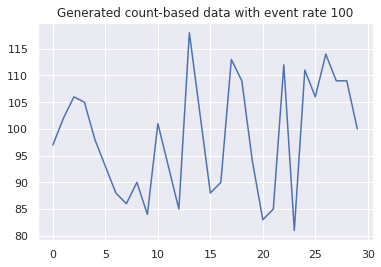

In [3]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
plt.plot(poisson(mu=100).rvs(size=30))
plt.title('Generated count-based data with event rate 100')
plt.show()

## Event rate $\lambda$ as dependent variable
The idea of Poisson regression is to say that event rate $\lambda$ is a dependent variable.

For instance the number of bicycles that cross a bridge per day depends on weather, time of the year, day of the week etc. We could build usual RMSE regression model, however such model would not account for the count-based properties of the data.  So in Poisson regression we would like to maximize log-likelihood for a Poisson distribution. Let $X$, $y$ be our dataset for Poisson regression task (meaning $y$ is count-based), then we want to maximize the log-likelihood:

$$\sum_{i=1}^{N} log(P_X(y)) = \sum_{i=1}^{N} log\left( \frac{e^{-\lambda(X_i) } (\lambda(X_i)) ^{y_i}}{y_i!} \right) = \sum_{i=1}^{N}\left( y_i \log (\lambda(X_i) ) - \lambda(X_i) - \log(y_i!) \right) $$

Since $\log(y_i !)$ does not depend on $X_i$ we drop this term and minimize the following loss:

$$L_{\text{poisson}} =  \sum_{i=1}^{N}\left(\lambda(X_i) - y_i \log (\lambda(X_i) )  \right)$$

This loss can be optimized with different models and optimization methods. In our tutorial we use CatBoost package.




## Training the Poisson regression model

In [0]:
import pandas as pd
import numpy as np
from catboost import CatBoost, Pool
from sklearn.metrics import r2_score, mean_squared_error

# Dataset
Our dataset is collected with Twitter api. It consists of Elon Musk tweets. We are going to use tweets from March 2019 to January 2020 as a train set and tweets from February 2020 as a test set. Features include number of user mentions and urls in tweet, features derived from posting date and tfidf vector of size 500. Our **target is number of likes** that tweets receive. In practice the majority of tweets receive all their likes during the first 2 weeks after publication, so we are going to assume that our time unit is two weeks. We collected the tweets that are at least two weeks old.
## Features

We extracted some quite simple features for our task:
* Tweet length 
* Number of other Twitter users mentions
* Number of urls in tweet
* Month
* Day
* Hour
* Day of week
* TF-IDF feature vector of size 500 (extracted with `sklearn.feature_extraction.text.TfidfVectorizer` with `stop_words="english"`)


In [0]:
df = pd.read_csv('elon_tweets.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

,id,n_mentions,n_urls,tweet_length,MONTH,DAY_OF_WEEK,DAY,HOUR,favorite_count,tfidf_000,tfidf_10,tfidf_100,tfidf_1000,tfidf_12,tfidf_13ericralph31,tfidf_20,tfidf_28delayslater,tfidf_30,tfidf_46txqrrsdr,tfidf_60,tfidf__mikemo,tfidf_able,tfidf_absolutely,tfidf_access,tfidf_actual,tfidf_actually,tfidf_add,tfidf_adding,tfidf_advanced,tfidf_aerojetrdyne,tfidf_ago,tfidf_agreed,tfidf_aiming,tfidf_air,tfidf_aircraft,tfidf_allow,tfidf_amazing,tfidf_amp,tfidf_analysis,tfidf_angelgponce,...,tfidf_using,tfidf_v10,tfidf_v_g_fischer,tfidf_vacuum,tfidf_value,tfidf_valueanalyst1,tfidf_ve,tfidf_vehicle,tfidf_vehicles,tfidf_version,tfidf_video,tfidf_vincent13031925,tfidf_volume,tfidf_vs,tfidf_want,tfidf_water,tfidf_way,tfidf_week,tfidf_weeks,tfidf_welcome,tfidf_wheel,tfidf_white,tfidf_wide,tfidf_win,tfidf_won,tfidf_work,tfidf_worked,tfidf_working,tfidf_works,tfidf_world,tfidf_worldandscience,tfidf_worth,tfidf_wow,tfidf_wrong,tfidf_wsj,tfidf_yeah,tfidf_year,tfidf_years,tfidf_yes,tfidf_zero
created_at,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-16 20:05:14+00:00,1107009951266824192,2,0,191,3,5,16,20,7271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:10:50+00:00,1107011362423599104,3,0,214,3,5,16,20,1401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:38:07+00:00,1107018227727491073,3,0,312,3,5,16,20,1420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:45:24+00:00,1107020062177714176,2,0,68,3,5,16,20,4001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:53:52+00:00,1107022190426247168,3,0,153,3,5,16,20,742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.177162,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.310738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_train = df[df.index < '2020-02-01']
df_test = df[(df.index >= '2020-02-01') & (df.index < '2020-03-01')]

In [0]:
train_pool = Pool(df_train.drop(['favorite_count', 'id'], 1),
                  label=df_train.favorite_count.values.astype(int)//100,
                  cat_features=['MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR'])
test_pool = Pool(df_test.drop(['favorite_count', 'id'], 1),
                 label=df_test.favorite_count.values.astype(int)//100,
                 cat_features=['MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR'])

In [0]:
actual_counts = df_test.favorite_count.values.astype(int)

Now we are going to train a CatBoost model with objective Poisson:

In [10]:
model = CatBoost({'objective' : 'Poisson'})

model.fit(train_pool, verbose=100)

predicted_counts_poisson = np.exp(model.predict(test_pool)) * 100
r2_poisson = r2_score(actual_counts, predicted_counts_poisson)
rmse_score_poisson_model = np.sqrt(mean_squared_error(actual_counts, predicted_counts_poisson))
print('R2 score: {:.3f}\nRMSE score: {:.2f}'.format(r2_poisson, rmse_score_poisson_model))

0:	learn: -37.1328755	total: 66.3ms	remaining: 1m 6s
100:	learn: -1208.8528151	total: 1.58s	remaining: 14.1s
200:	learn: -1233.5111754	total: 3.08s	remaining: 12.3s
300:	learn: -1243.6157439	total: 4.62s	remaining: 10.7s
400:	learn: -1251.8941410	total: 6.22s	remaining: 9.29s
500:	learn: -1261.2416848	total: 7.82s	remaining: 7.79s
600:	learn: -1267.6028685	total: 9.41s	remaining: 6.25s
700:	learn: -1273.1120966	total: 11s	remaining: 4.7s
800:	learn: -1277.4624042	total: 12.6s	remaining: 3.13s
900:	learn: -1281.7142932	total: 14.2s	remaining: 1.56s
999:	learn: -1284.9729676	total: 15.7s	remaining: 0us
R2 score: 0.513
RMSE score: 34389.62


Coefficient of determination R2 value of 51% suggest that the predictions of our model on the test dataset explain more than a half of the target variability, which is not bad given the complexity of the task and the simplicity of our approach.

Also for comparison we are going to train a CatBoost model with standard RMSE objective: 

In [11]:
model = CatBoost({'objective' : 'RMSE'})

model.fit(train_pool, verbose=100)

predicted_counts_rmse = model.predict(test_pool) * 100
r2_rmse = r2_score(actual_counts, predicted_counts_rmse)
rmse_score_rmse_model = np.sqrt(mean_squared_error(actual_counts, predicted_counts_rmse))
print('R2 score: {:.3f}\nRMSE score: {:.2f}'.format(r2_rmse, rmse_score_rmse_model))

Learning rate set to 0.046257
0:	learn: 601.0989714	total: 14.3ms	remaining: 14.3s
100:	learn: 436.0929436	total: 1.3s	remaining: 11.6s
200:	learn: 407.0127144	total: 2.6s	remaining: 10.4s
300:	learn: 381.9581937	total: 3.97s	remaining: 9.21s
400:	learn: 361.3012961	total: 5.33s	remaining: 7.96s
500:	learn: 344.6548816	total: 6.71s	remaining: 6.68s
600:	learn: 331.4506209	total: 8.1s	remaining: 5.38s
700:	learn: 318.7518751	total: 9.5s	remaining: 4.05s
800:	learn: 309.1305116	total: 10.9s	remaining: 2.7s
900:	learn: 293.5494927	total: 12.3s	remaining: 1.35s
999:	learn: 286.0811425	total: 13.7s	remaining: 0us
R2 score: 0.458
RMSE score: 36298.05


 | | CatBoost-RMSE | CatBoost-Poisson 
--- | --- | ---
R2 score | 0.458 | 0.513 (+12%)
RMSE | 36298 | 34389 (-5%)
 
As can be seen the loss that accounts for the nature of the dataset yields better results than the standard RMSE loss. 

In [0]:
import plotly.express as px
import plotly.graph_objects as go

In [13]:
fig = go.Figure()
fig.update_layout(title={'text': "Elon Musk tweets likes prediction", 'x':0.4})
fig.add_trace(go.Scatter(go.Scatter(x=df_test.index, y=actual_counts, mode='markers', name='Actual likes')))
fig.add_trace(go.Scatter(go.Scatter(x=df_test.index, y=predicted_counts_poisson, mode='markers', marker_line_width=1, marker_size=10, marker_color='green', marker_symbol='circle-open',
                                    name='CatBoost-Poisson')))

**Thank you for your attention! I hope you find this tutorial useful.**